In [7]:
#RUN THIS CELL ONCE PER LOAD

#Global Value for number of tweets and begining date
num_tweets = 250
#imports
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import itertools
import os
import tweepy as tw
import pickle
from datetime import date
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
from nltk.classify import NaiveBayesClassifier
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
#load Naive Bayes classifier from pickle
f = open('my_classifier.pickle', 'rb')
classifier = pickle.load(f)
f.close()

#Twitter API
import config
consumer_key = config.consumer_key
consumer_secret = config.consumer_secret
access_token = config.access_token
access_token_secret = config.access_token_secret

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

#Defines functions to be used in program

#Cleans HTML Input from string
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html) 
  return TextBlob(cleantext.lower())

# This is how the Naive Bayes classifier expects the input
# removes stopwords from string
# returns a dictionary
def create_word_features(words):
    useful_words = [word for word in words if word not in stopwords.words("english")]
    my_dict = dict([(word, True) for word in useful_words])
    return my_dict

# removes stopwords from string
# returns a dictionary
def create_tweet_features(words):
    split = words.split(' ')
    useful_words = [word for word in split if word not in stopwords.words("english")]
    my_dict = dict([(word, True) for word in useful_words])
    return my_dict

#Process Input
def findusefulwords(arr, sentiment):
    unique_words = {}
    useful_words = []

    for x in range (arr[0].size):
       unique_words[x] = set(cleanhtml(arr[0][x]).split(' '))

    for x in range (len(unique_words)):
        useful_words.append((create_word_features(unique_words[x]), sentiment))
    return useful_words

def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

#Search twitter API
def searchTwitter(search_string):
    search_string = search_string + "-filter:retweets"
    today = date.today()
    d1 = today.strftime("%d/%m/%Y")
    tweets = tw.Cursor(api.search,
                       q=search_string,
                       lang="en",
                       since='2019/01/01').items(num_tweets)
    all_tweets = [remove_url(tweet.text).lower() for tweet in tweets]
    searchTwitter.total_tweets = len(all_tweets)
    return all_tweets

#Classify Tweets
def classifyTweets(tweets):
    tokenizedTweets = []
    positive = 0
    negative = 0
    tweet_list = []
    negative_list = []
    positive_list = []
    for x in range (len(tweets)):
        tweet_list.append(tweets[x])
        tokenizedTweet = (create_tweet_features(tweets[x]))
        if classifier.classify(tokenizedTweet) == 'positive':
          positive_list.append(tweets[x])
          positive = positive+1
        elif classifier.classify(tokenizedTweet) == 'negative':
          negative = negative + 1
          negative_list.append(tweets[x])
    #if no tweets of one kind set it to one and add blank entry to list so it doesnt break
    if negative == 0:
      print('No negatives')
      negative_list.append(' ')
    if positive == 0:
      print('No positives')
      positive_list.append(' ')
    classifyTweets.num_pos = positive
    classifyTweets.num_neg = negative
    classifyTweets.positive = percentage(positive, searchTwitter.total_tweets)
    classifyTweets.negative = percentage(negative, searchTwitter.total_tweets)
    classifyTweets.tweet_list = pd.DataFrame(tweet_list)
    classifyTweets.negative_list = pd.DataFrame(negative_list)
    classifyTweets.positive_list = pd.DataFrame(positive_list)
    classifyTweets.tweet_list.drop_duplicates(inplace = True)
    classifyTweets.negative_list.drop_duplicates(inplace = True)
    classifyTweets.positive_list.drop_duplicates(inplace = True)

    if (negative > positive):
        return 'Negative'
    else:
        return "Positive"

def percentage(part,whole):
    if part == 0:
        return 0
    return 100 * float(part)/float(whole)

def create_wordcloud(text):
  mask = np.array(Image.open('cloud.png'))
  stopwords = set(STOPWORDS)
  wc = WordCloud(background_color='white',
  mask = mask,
  max_words=3000,
  stopwords=stopwords,
  repeat=True)
  wc.generate(str(text))
  wc.to_file('wc.png')
  path='wc.png'
  display(Image.open(path))
  return

def displayResults(search_string):
  num_pos = (classifyTweets.num_pos)
  num_neg = (classifyTweets.num_neg)
  positive = classifyTweets.positive
  negative = classifyTweets.negative
  print("% Tweets Postive : " ,positive, "% or ", num_pos, " / ", searchTwitter.total_tweets, " tweets")
  print("% Tweets Negative : " ,negative, "% or ", num_neg, " / ", searchTwitter.total_tweets, " tweets")

  #Creating PieCart
  labels = ['Positive ['+str(positive)+'%]','Negative ['+str(negative)+'%]']
  colors = ['blue','red']
  sizes = [positive, negative]
  patches, texts = plt.pie(sizes,colors=colors, startangle=90)
  plt.style.use('default')
  plt.legend(labels)
  plt.title('Twitter Sentiment Analysis Result for search : '+search_string+'' )
  plt.axis('equal')
  plt.show()  
  #max length of a tweet is 280 chars
  pd.options.display.max_colwidth = 280
  if classifyTweets.num_pos != 0:
    print("Postive")
    create_wordcloud(classifyTweets.positive_list.values)
  if classifyTweets.num_neg != 0:
    print("Negative")
    create_wordcloud(classifyTweets.negative_list.values)
  return

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\auggi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
#This cell creates the Naive Bayes Classifier Algorithm, 
#you do not need to run this cell since the classifier is saved into the pickle file

#seperate data into pos and neg reviews, find the useful words for each and save to pos_words and neg_words

#Read in Datafile
df = pd.read_csv('IMDBDataset.csv',engine='python', encoding='utf-8', error_bad_lines=False).to_numpy()
size = int(df.size/2)
pos_reviews = []
neg_reviews = []

for x in range (size):
    if(df[x][1] == 'positive'):
        pos_reviews.append((df[x]))
    elif(df[x][1] == 'negative'):
        neg_reviews.append((df[x]))
pos_reviews = np.array(pos_reviews).T
pos_words = findusefulwords(pos_reviews,"positive")

neg_reviews = np.array(neg_reviews).T
neg_words = findusefulwords(neg_reviews,"negative")

words = neg_words + pos_words
X_train, X_test = train_test_split(words, random_state=0)
classifier = NaiveBayesClassifier.train(X_train)

#Train the classifier and save it using pickle
#Classify and save to pickle
classifier = NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.util.accuracy(classifier, X_test)
print(accuracy * 100)
# classifier.show_most_informative_features()
f = open('my_classifier.pickle', 'wb')
pickle.dump(classifier, f)
f.close()

76.032


In [73]:
#confusion matrix
test_result = []
gold_result = []
for i in range(len(X_test)):
    test_result.append(classifier.classify(X_test[i][0]))
    gold_result.append(X_test[i][1])

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix   

print("\nClasification report:\n", classification_report(gold_result, test_result))
print("\nConfussion matrix:\n",confusion_matrix(gold_result, test_result))


Clasification report:
               precision    recall  f1-score   support

    negative       0.80      0.70      0.75      6291
    positive       0.73      0.82      0.77      6209

    accuracy                           0.76     12500
   macro avg       0.76      0.76      0.76     12500
weighted avg       0.76      0.76      0.76     12500


Confussion matrix:
 [[4414 1877]
 [1119 5090]]


Enter a string to search : NFL
Twitter Sentiment of  NFL  :  Positive
% Tweets Postive :  68.0 % or  170  /  250  tweets
% Tweets Negative :  32.0 % or  80  /  250  tweets


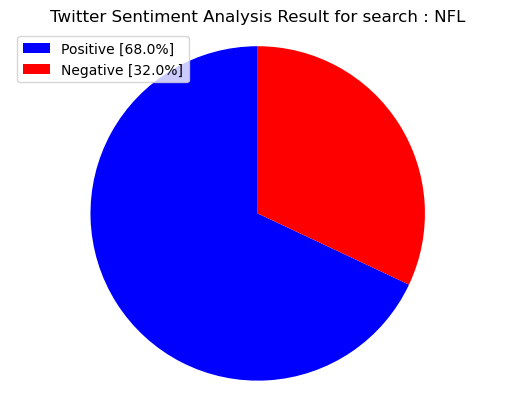

Postive


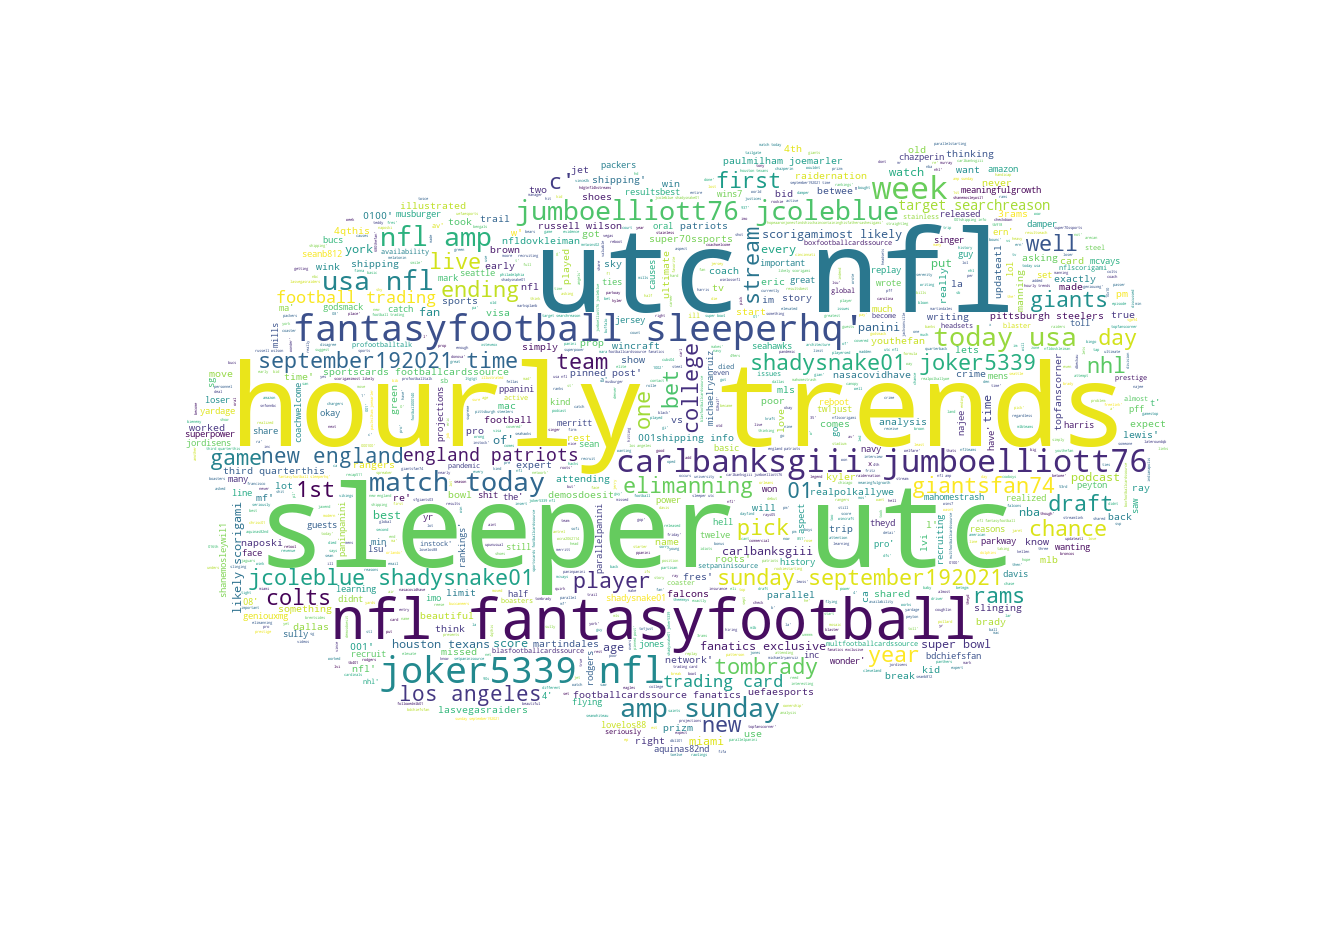

Negative


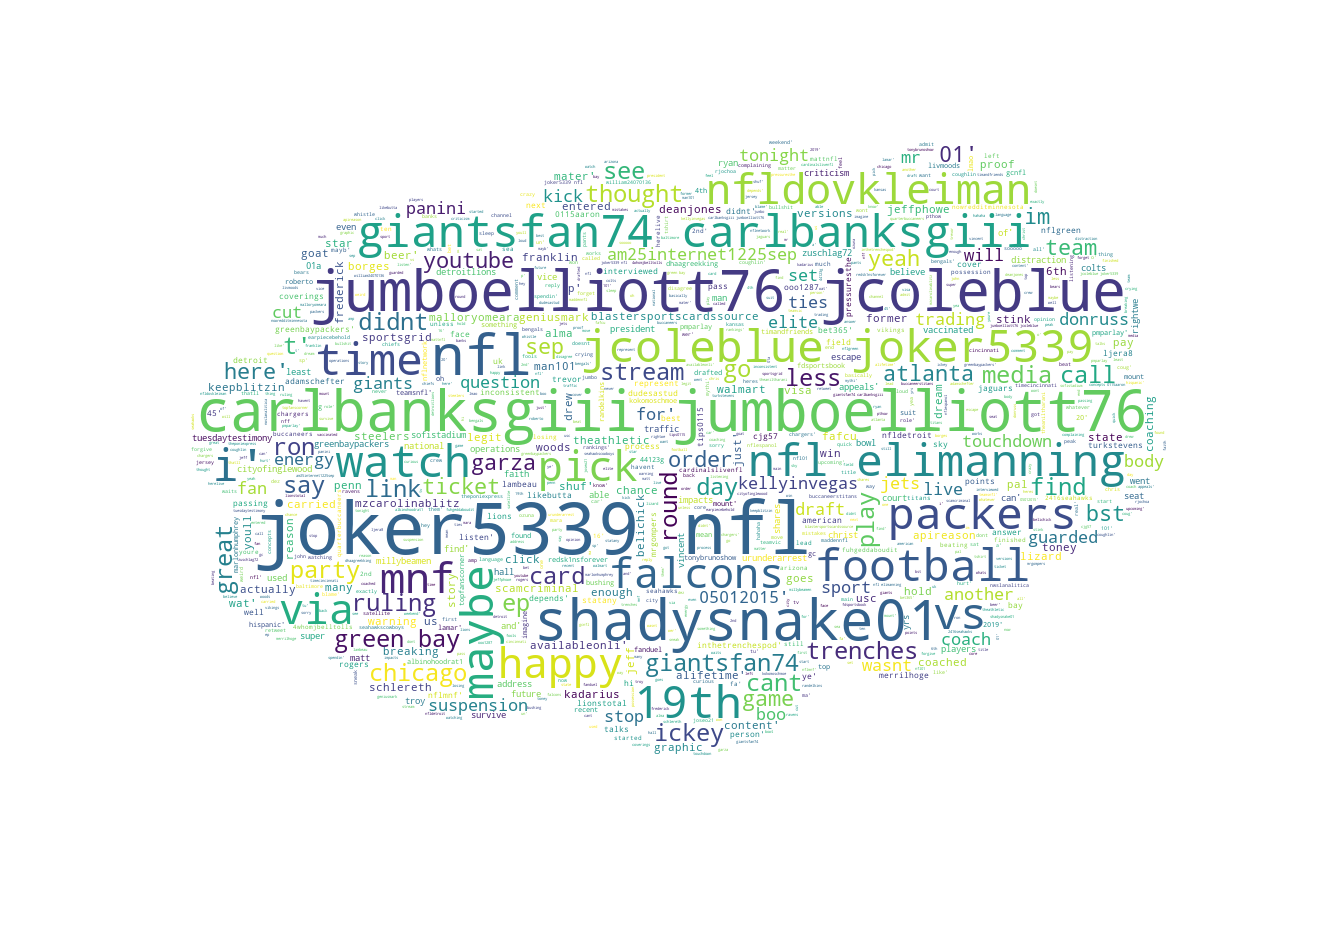

In [10]:
#Sentiment Analysis Using the naive bayes classifier trained on movie data
search = input("Enter a string to search : ")
tweets = searchTwitter(search)
sentiment = classifyTweets(tweets)
print("Twitter Sentiment of " , search, " : ", sentiment)
displayResults(search)